In [1]:
#Group Project Script
#Ethan Fischbein

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StringType,BooleanType,DateType, IntegerType
from pyspark.sql.functions import to_timestamp, upper, col

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
spark = SparkSession.builder.appName('ZillowPrices').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g'), ('spark.sql.repl.eagerEval.enabled', True)])


# DATA EXPLORATION, DATASET CREATION

In [4]:
#SECTION 1 - Load base CSV file & analyze
df = spark.read.csv("gs://group-8-msca-bucket/sales.csv", inferSchema=True, header=True)

In [ ]:
df.describe()

DataFrame[summary: string, state: string, zip5: string, physical_address: string, city: string, county: string, property_id: string, sale_date: string, property_type: string, sale_price: string, seller_name: string, buyer_name: string, num_units: string, year_built: string, source_url: string, book: string, page: string]

In [ ]:
df.show(3)

+-----+-----+-----------------+-------+---------+-----------+--------------------+--------------------+----------+-----------+----------+---------+----------+--------------------+----+----+
|state| zip5| physical_address|   city|   county|property_id|           sale_date|       property_type|sale_price|seller_name|buyer_name|num_units|year_built|          source_url|book|page|
+-----+-----+-----------------+-------+---------+-----------+--------------------+--------------------+----------+-----------+----------+---------+----------+--------------------+----+----+
|   CA|92220|1050 THOMPSON AVE|BANNING|RIVERSIDE|  408144009|1988-05-25 00:00:...|SINGLE FAMILY DWE...|         0|       null|      null|        1|      1965|https://ca-rivers...|null|null|
|   CA|92220|1050 THOMPSON AVE|BANNING|RIVERSIDE|  408144009|1989-03-17 00:00:...|SINGLE FAMILY DWE...|         0|       null|      null|        1|      1965|https://ca-rivers...|null|null|
|   CA|92220|1050 THOMPSON AVE|BANNING|RIVERSIDE| 

In [ ]:
df.dtypes

[('state', 'string'),
 ('zip5', 'string'),
 ('physical_address', 'string'),
 ('city', 'string'),
 ('county', 'string'),
 ('property_id', 'string'),
 ('sale_date', 'string'),
 ('property_type', 'string'),
 ('sale_price', 'string'),
 ('seller_name', 'string'),
 ('buyer_name', 'string'),
 ('num_units', 'string'),
 ('year_built', 'string'),
 ('source_url', 'string'),
 ('book', 'string'),
 ('page', 'string')]

In [ ]:
#SECTION 2 - Data Cleanup
#1. drop extra columns (seller_name, buyer_name, source_url, book, page)
#2. Dates - limited from 1970-2021
#3. Sale Price - not null, greater than 0
#4. City, State - remove null
#5. Num. Units -  must be 1
#6. Property Type - remove condos, mobile homes
#7. Num. Sales - must be greater than 1

In [5]:
#Data Cleanup - drop extra columns
df = df.drop("seller_name", "buyer_name", "source_url", "book", "page")

In [6]:
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt

/opt/conda/anaconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


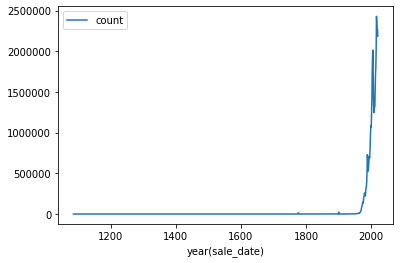

In [ ]:
#home sales by year
sale_plt = df.filter(F.year(col('sale_date')) <= 2020).groupBy(F.year(col('sale_date'))).count().toPandas()
sale_plt = sale_plt.sort_values('year(sale_date)')
sale_plt = sale_plt.set_index('year(sale_date)')
sale_plt.plot(kind ='line')
plt.show()

In [7]:
#Data Cleanup - Dates: 1970 - 2021
df = df.withColumn('sale_date', F.to_date(F.unix_timestamp('sale_date', 'yyyy-MM-dd').cast('timestamp')))
df = df.filter((F.year(col("sale_date"))<=2021) & (F.year(col("sale_date"))>=1970))
df.select('sale_date').head(5)

[Row(sale_date=datetime.date(1988, 5, 25)),
 Row(sale_date=datetime.date(1989, 3, 17)),
 Row(sale_date=datetime.date(1991, 6, 18)),
 Row(sale_date=datetime.date(1994, 12, 12)),
 Row(sale_date=datetime.date(2003, 2, 28))]

In [8]:
#Data Cleanup - Sale Price
df = df.withColumn('sale_price', df.sale_price.cast('float'))
df = df.filter(col("sale_price").isNotNull()).filter(col("sale_price")>0)
df.select('sale_price').head(5)

[Row(sale_price=59000.0),
 Row(sale_price=280000.0),
 Row(sale_price=381591.0),
 Row(sale_price=592000.0),
 Row(sale_price=585000.0)]

In [ ]:
df.describe("sale_date", "sale_price").show()

+-------+-----------------+
|summary|       sale_price|
+-------+-----------------+
|  count|         42865931|
|   mean|493120.9679655622|
| stddev|6699651.508783256|
|    min|              1.0|
|    max|            8.2E9|
+-------+-----------------+



In [9]:
#Data Cleanup - remove null cities & states
df = df.filter((col("city").isNotNull()) & (col("state").isNotNull()) & (col("physical_address").isNotNull()) & (col("zip5").isNotNull()))

In [ ]:
#top cities
df.groupBy('city','state').count().orderBy('count', ascending=False).show(10)

+--------------------+-----+-------+
|                city|state|  count|
+--------------------+-----+-------+
|         LOS ANGELES|   CA|1403176|
|       NEW YORK CITY|   NY|1260613|
|               TAMPA|   FL|1074407|
|        PHILADELPHIA|   PA| 738332|
|            LAKELAND|   FL| 542238|
|             SEATTLE|   WA| 413323|
|      VIRGINIA BEACH|   VA| 365435|
|        INDIANAPOLIS|   IN| 329493|
|           DAVENPORT|   FL| 306982|
|UNINCORPORATED CO...|   FL| 303591|
+--------------------+-----+-------+
only showing top 10 rows



In [10]:
#Data Cleanup - View number of units, want to only be 1
df = df.filter(col('num_units')==1)
df.groupBy('num_units').count().orderBy('count', ascending=False).show()

+---------+-------+
|num_units|  count|
+---------+-------+
|        1|9742796|
+---------+-------+



In [ ]:
#view property types
df.groupBy('property_type').count().orderBy('count', ascending=False).show()

+--------------------+-------+
|       property_type|  count|
+--------------------+-------+
|SINGLE FAMILY RES...|2579548|
|                null|2104659|
|SINGLE FAMILY DWE...|1402975|
|         CONDOMINIUM| 784499|
|SINGLE FAMILY/SFR...| 440753|
|       SINGLE FAMILY| 421979|
|          ONE FAMILY| 301540|
|     SINGLE FAMILY R| 297952|
|       SINGLE-FAMILY| 179918|
|RESIDENTIAL < 10 ...| 158199|
|13  CONDOS - ELEV...| 148473|
|MULTI-FAMILY RESI...| 137634|
|01  ONE FAMILY HOMES| 126917|
|MOBILE HOME/MANUF...|  96049|
|13 CONDOS - ELEVA...|  83340|
|01 ONE FAMILY DWE...|  62157|
|01  ONE FAMILY DW...|  46209|
|      CONDO/TOWNHOME|  43164|
|ATTACHED HOUSING/...|  24802|
|28  COMMERCIAL CO...|  24360|
+--------------------+-------+
only showing top 20 rows



In [11]:
#Data Cleanup - filter out condos, mobile homes, rentals
df = df.where(~ col("property_type").like("%CONDO%"))
df = df.where(~ col("property_type").like("%MOBILE%HOME%"))
df = df.where(~ col("property_type").like("%RENTALS%"))

In [ ]:
#view top properties
df.groupBy('city','state', 'physical_address', 'zip5', 'property_type').count().orderBy('count', ascending=False).show(25)

+------------+-----+--------------------+-----+--------------------+-----+
|        city|state|    physical_address| zip5|       property_type|count|
+------------+-----+--------------------+-----+--------------------+-----+
|PALM SPRINGS|   CA|  1800 S SUNRISE WAY|92264|SINGLE FAMILY DWE...|  106|
|PHILADELPHIA|   PA|   2018-32 WALNUT ST|19103|       SINGLE FAMILY|  102|
|  LONG BEACH|   CA|        225 W 6TH ST|90802|SINGLE FAMILY RES...|   97|
|PHILADELPHIA|   PA|        112 N 2ND ST|19106|       SINGLE FAMILY|   93|
|    LAKELAND|   FL|  2020 EDGEWOOD DR E|33803|ATTACHED HOUSING/...|   91|
|  LAKE WALES|   FL|   2300 SCENIC HWY N|33898|SINGLE FAMILY/SFR...|   86|
|PHILADELPHIA|   PA|224-30 W RITTENHO...|19103|       SINGLE FAMILY|   81|
|  LAKE WALES|   FL|   2285 BOY SCOUT RD|33853|SINGLE FAMILY/MUL...|   70|
|  LAKE WALES|   FL|   2300 SCENIC HWY N|33853|SINGLE FAMILY/SFR...|   62|
|  LAKE WALES|   FL|   2300 SCENIC HWY N|33898|SINGLE FAMILY/RES...|   61|
|PHILADELPHIA|   PA|2401 

In [12]:
from pyspark.sql.functions import rank
from pyspark.sql.window import Window

In [13]:
#Data Cleanup - filter dataframe based on window function to only show properties with only 1 sale
windowSpec = Window().partitionBy(['city','state', 'physical_address', 'zip5']).rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df = df.withColumn("num_sales", F.count(col('city')).over(windowSpec)).filter(col('num_sales') > 1)

In [ ]:
#SECTION 3 - Join Predictive Data Features

In [ ]:
#SECTION 3a - Public Schools data

In [14]:
#Public_Schools.csv
Public_Schools = spark.read.csv("gs://group-8-msca-bucket/Public_Schools.csv", inferSchema=True, header=True)

In [ ]:
Public_Schools.describe()

In [ ]:
Public_Schools.dtypes
#Can maybe use the count of schools by city as a predictor? But would be correlated with city size

In [15]:
#Public schools - First predictor variable - raw count by zip code
num_schools_zip = Public_Schools.groupby('ZIP').count()
num_schools_zip

DataFrame[ZIP: string, count: bigint]

In [16]:
#join predictor to base table
df = df.join(num_schools_zip, df['zip5'] == num_schools_zip['ZIP'], 'left').\
    select(df["*"],num_schools_zip["count"]).na.fill(0)

In [17]:
df = df.withColumnRenamed('count','zip_num_schools')
df.show(5)

+-----+-----+--------------------+-----+-----------+-----------+----------+--------------------+----------+---------+----------+---------+---------------+
|state| zip5|    physical_address| city|     county|property_id| sale_date|       property_type|sale_price|num_units|year_built|num_sales|zip_num_schools|
+-----+-----+--------------------+-----+-----------+-----------+----------+--------------------+----------+---------+----------+---------+---------------+
|   CA|93510|        1629 MARY RD|ACTON|LOS ANGELES| 3057028002|2002-01-10|SINGLE FAMILY RES...| 7303573.0|        1|      2003|        3|              5|
|   CA|93510|        1629 MARY RD|ACTON|LOS ANGELES| 3057028002|2003-09-17|SINGLE FAMILY RES...|  458000.0|        1|      2003|        3|              5|
|   CA|93510|        1629 MARY RD|ACTON|LOS ANGELES| 3057028002|2012-08-02|SINGLE FAMILY RES...|  399003.0|        1|      2003|        3|              5|
|   CA|93510|1940 SHADOW CANYO...|ACTON|LOS ANGELES| 3056032042|1991-0

In [18]:
#Public schools - Second predictor variable - number of schools by city
num_schools_city = Public_Schools.groupby('city', 'state').count()
num_schools_city

DataFrame[city: string, state: string, count: bigint]

In [19]:
#join predictor to base table
df = df.join(num_schools_city, (df['city'] == num_schools_city['city']) & \
             (df['state'] == num_schools_city['state']), 'left').\
             select(df["*"],num_schools_city["count"]).na.fill(0)

In [20]:
df = df.withColumnRenamed('count','city_num_schools')
df.show(5)

+-----+-----+--------------------+-----+-----------+-----------+----------+--------------------+----------+---------+----------+---------+---------------+----------------+
|state| zip5|    physical_address| city|     county|property_id| sale_date|       property_type|sale_price|num_units|year_built|num_sales|zip_num_schools|city_num_schools|
+-----+-----+--------------------+-----+-----------+-----------+----------+--------------------+----------+---------+----------+---------+---------------+----------------+
|   CA|93510|        1629 MARY RD|ACTON|LOS ANGELES| 3057028002|2002-01-10|SINGLE FAMILY RES...| 7303573.0|        1|      2003|        3|              5|               5|
|   CA|93510|        1629 MARY RD|ACTON|LOS ANGELES| 3057028002|2003-09-17|SINGLE FAMILY RES...|  458000.0|        1|      2003|        3|              5|               5|
|   CA|93510|        1629 MARY RD|ACTON|LOS ANGELES| 3057028002|2012-08-02|SINGLE FAMILY RES...|  399003.0|        1|      2003|        3|  

In [21]:
#Public schools - Third predictor variable - Student Teacher Ratio by Zip
st_ratio_zip = Public_Schools.filter((col('ENROLLMENT') != -1) & (col('FT_TEACHER') != -1))
st_ratio_zip = st_ratio_zip.groupby('ZIP').agg((F.sum(st_ratio_zip.ENROLLMENT) / F.sum(st_ratio_zip.FT_TEACHER)).alias('zip_st_ratio'))
st_ratio_zip.show(5, vertical=True)

-RECORD 0--------------------------
 ZIP          | 39645              
 zip_st_ratio | 11.71111111111111  
-RECORD 1--------------------------
 ZIP          | 11563              
 zip_st_ratio | 11.840637450199203 
-RECORD 2--------------------------
 ZIP          | 92027              
 zip_st_ratio | 21.91578947368421  
-RECORD 3--------------------------
 ZIP          | 35670              
 zip_st_ratio | 16.495495495495497 
-RECORD 4--------------------------
 ZIP          | 36067              
 zip_st_ratio | 20.16058394160584  
only showing top 5 rows



In [22]:
#join predictor to base table
df = df.join(st_ratio_zip, df['zip5'] == st_ratio_zip['ZIP'], 'left').\
    select(df["*"],st_ratio_zip["zip_st_ratio"])

In [23]:
#Public schools - Fourth predictor variable - Student Teacher Ratio by City
st_ratio_city = Public_Schools.filter((col('ENROLLMENT') != -1) & (col('FT_TEACHER') != -1))
st_ratio_city = st_ratio_city.groupby('city', 'state').agg((F.sum(st_ratio_city.ENROLLMENT) / F.sum(st_ratio_city.FT_TEACHER)).alias('city_st_ratio'))
st_ratio_city.show(5, vertical=True)

-RECORD 0---------------------------
 city          | STATEN ISLAND      
 state         | NY                 
 city_st_ratio | 14.711904202864522 
-RECORD 1---------------------------
 city          | MARLBORO           
 state         | NJ                 
 city_st_ratio | 12.857923497267759 
-RECORD 2---------------------------
 city          | JERICHO            
 state         | VT                 
 city_st_ratio | 14.813084112149532 
-RECORD 3---------------------------
 city          | WOODLYNNE          
 state         | NJ                 
 city_st_ratio | 11.575757575757576 
-RECORD 4---------------------------
 city          | HANOVER            
 state         | MA                 
 city_st_ratio | 12.744094488188976 
only showing top 5 rows



In [24]:
#join predictor to base table
df = df.join(st_ratio_city, (df['city'] == st_ratio_city['city']) & \
             (df['state'] == st_ratio_city['state']), 'left').\
             select(df["*"],st_ratio_city["city_st_ratio"]).na.fill(0)

In [25]:
df.show(10, vertical=True)

-RECORD 0--------------------------------
 state            | CA                   
 zip5             | 93510                
 physical_address | 1629 MARY RD         
 city             | ACTON                
 county           | LOS ANGELES          
 property_id      | 3057028002           
 sale_date        | 2002-01-10           
 property_type    | SINGLE FAMILY RES... 
 sale_price       | 7303573.0            
 num_units        | 1                    
 year_built       | 2003                 
 num_sales        | 3                    
 zip_num_schools  | 5                    
 city_num_schools | 5                    
 zip_st_ratio     | 22.85185185185185    
 city_st_ratio    | 22.85185185185185    
-RECORD 1--------------------------------
 state            | CA                   
 zip5             | 93510                
 physical_address | 1629 MARY RD         
 city             | ACTON                
 county           | LOS ANGELES          
 property_id      | 3057028002    

In [ ]:
#SECTION 3b - Housing CPI
#Limitations, not specific to regions

In [28]:
#CPI
CPI = spark.read.csv("gs://group-8-msca-bucket/CPIHOSNS.csv", inferSchema=True, header=True)

In [ ]:
CPI.dtypes

In [29]:
CPI = CPI.withColumn('month', F.month(col('DATE')))
CPI = CPI.withColumn('year', F.year(col('DATE')))
CPI.show(5)

+-------------------+--------+-----+----+
|               DATE|CPIHOSNS|month|year|
+-------------------+--------+-----+----+
|1967-01-01 00:00:00|    30.5|    1|1967|
|1967-02-01 00:00:00|    30.5|    2|1967|
|1967-03-01 00:00:00|    30.5|    3|1967|
|1967-04-01 00:00:00|    30.6|    4|1967|
|1967-05-01 00:00:00|    30.7|    5|1967|
+-------------------+--------+-----+----+
only showing top 5 rows



In [30]:
#join predictor to base table
df = df.join(CPI, (F.month(df['sale_date']) == CPI['month']) & \
             (F.year(df['sale_date']) == CPI['year']), 'left').\
             select(df["*"],CPI["CPIHOSNS"])

In [ ]:
df.show(10, vertical=True)

In [ ]:
#SECTION 3c - ZVHI
#Limitations, not all regions included, will leave as 0

In [33]:
#ZVHI
ZVHI = spark.read.csv("gs://group-8-msca-bucket/ZHVI_cln.csv", inferSchema=True, header=True)
ZVHI.head(5)

[Row(Date='1/31/2000', RegionID=102001, SizeRank=0, RegionName='United States', RegionType='Country', StateName='0', ZVHI=127090),
 Row(Date='2/29/2000', RegionID=102001, SizeRank=0, RegionName='United States', RegionType='Country', StateName='0', ZVHI=127434),
 Row(Date='3/31/2000', RegionID=102001, SizeRank=0, RegionName='United States', RegionType='Country', StateName='0', ZVHI=127795),
 Row(Date='4/30/2000', RegionID=102001, SizeRank=0, RegionName='United States', RegionType='Country', StateName='0', ZVHI=128532),
 Row(Date='5/31/2000', RegionID=102001, SizeRank=0, RegionName='United States', RegionType='Country', StateName='0', ZVHI=129274)]

In [34]:
ZVHI = ZVHI.withColumn('Date', F.to_date(F.unix_timestamp('Date', 'MM/dd/yyyy').cast('timestamp')))
ZVHI.select('Date').head(5)

[Row(Date=datetime.date(2000, 1, 31)),
 Row(Date=datetime.date(2000, 2, 29)),
 Row(Date=datetime.date(2000, 3, 31)),
 Row(Date=datetime.date(2000, 4, 30)),
 Row(Date=datetime.date(2000, 5, 31))]

In [ ]:
ZVHI.dtypes
#time series; could be useful to pivot, but seems redundant to the city index CSV

In [35]:
#filter out nationwide records
ZVHI = ZVHI.filter((ZVHI['RegionType'] == 'Msa') & (ZVHI['ZVHI'] > 0)) \
    .groupBy('StateName', 'Date').agg(F.mean(col('ZVHI')) \
    .alias('ZVHI')).orderBy('StateName', 'Date')

In [36]:
#add month, year columns
ZVHI = ZVHI.withColumn('month', F.month(col('DATE')))
ZVHI = ZVHI.withColumn('year', F.year(col('DATE')))

In [37]:
#ZVHI - join on city name
df = df.join(ZVHI, \
             (F.month(df['sale_date']) == ZVHI['month']) & (F.year(df['sale_date']) == ZVHI['year']) \
             & (df['state'] == ZVHI['StateName']), 'left').select(df["*"],ZVHI["ZVHI"]).na.fill(0)
df.show(5,vertical=True)

-RECORD 0--------------------------------
 state            | CA                   
 zip5             | 93510                
 physical_address | 1629 MARY RD         
 city             | ACTON                
 county           | LOS ANGELES          
 property_id      | 3057028002           
 sale_date        | 2002-01-10           
 property_type    | SINGLE FAMILY RES... 
 sale_price       | 7303573.0            
 num_units        | 1                    
 year_built       | 2003                 
 num_sales        | 3                    
 zip_num_schools  | 5                    
 city_num_schools | 5                    
 zip_st_ratio     | 22.85185185185185    
 city_st_ratio    | 22.85185185185185    
 CPIHOSNS         | 177.6                
 ZVHI             | 261132.8076923077    
-RECORD 1--------------------------------
 state            | CA                   
 zip5             | 93510                
 physical_address | 1629 MARY RD         
 city             | ACTON         

In [ ]:
#SECTION 3d - Income

In [39]:
#Income
Income = spark.read.csv("gs://group-8-msca-bucket/Census_Income", inferSchema=True, header=True)

In [ ]:
Income.show(5, vertical = True)

In [40]:
#limit columns
income_df = Income.select('Year', 'Geographic Area Name', 'Households!!Estimate!!Median income (dollars)')
income_df.show(5, vertical=True)

-RECORD 0----------------------------------------------------
 Year                                          | 2014        
 Geographic Area Name                          | ZCTA5 00601 
 Households!!Estimate!!Median income (dollars) | 10833       
-RECORD 1----------------------------------------------------
 Year                                          | 2014        
 Geographic Area Name                          | ZCTA5 00602 
 Households!!Estimate!!Median income (dollars) | 16353       
-RECORD 2----------------------------------------------------
 Year                                          | 2014        
 Geographic Area Name                          | ZCTA5 00603 
 Households!!Estimate!!Median income (dollars) | 16323       
-RECORD 3----------------------------------------------------
 Year                                          | 2014        
 Geographic Area Name                          | ZCTA5 00606 
 Households!!Estimate!!Median income (dollars) | 14138       
-RECORD 

In [ ]:
#verify years
income_df.select('Year').distinct().orderBy('year').show()

In [41]:
#clean zip column
income_df = income_df.withColumn('Zip', F.substring(col('Geographic Area Name'), -5, 5))
income_df.show(5,vertical=True)

-RECORD 0----------------------------------------------------
 Year                                          | 2014        
 Geographic Area Name                          | ZCTA5 00601 
 Households!!Estimate!!Median income (dollars) | 10833       
 Zip                                           | 00601       
-RECORD 1----------------------------------------------------
 Year                                          | 2014        
 Geographic Area Name                          | ZCTA5 00602 
 Households!!Estimate!!Median income (dollars) | 16353       
 Zip                                           | 00602       
-RECORD 2----------------------------------------------------
 Year                                          | 2014        
 Geographic Area Name                          | ZCTA5 00603 
 Households!!Estimate!!Median income (dollars) | 16323       
 Zip                                           | 00603       
-RECORD 3----------------------------------------------------
 Year   

In [42]:
#Income - join on city name
df = df.join(income_df, \
             (F.year(df['sale_date']) == income_df['Year']) & (df['zip5'] == income_df['Zip']), 'left')
df.show(5,vertical=True)

-RECORD 0-------------------------------------------------------------
 state                                         | CA                   
 zip5                                          | 93510                
 physical_address                              | 1629 MARY RD         
 city                                          | ACTON                
 county                                        | LOS ANGELES          
 property_id                                   | 3057028002           
 sale_date                                     | 2002-01-10           
 property_type                                 | SINGLE FAMILY RES... 
 sale_price                                    | 7303573.0            
 num_units                                     | 1                    
 year_built                                    | 2003                 
 num_sales                                     | 3                    
 zip_num_schools                               | 5                    
 city_

In [43]:
#Income
pre_2000 = spark.read.csv("gs://group-8-msca-bucket/county_pre_2000_data_cln.csv", header=True)
pre_2000.show(5, vertical=True)

-RECORD 0---------------
 Region | United States 
 Year   | 1969          
 Income | 8486          
-RECORD 1---------------
 Region | United States 
 Year   | 1970          
 Income | 8486          
-RECORD 2---------------
 Region | United States 
 Year   | 1971          
 Income | 8486          
-RECORD 3---------------
 Region | United States 
 Year   | 1972          
 Income | 8486          
-RECORD 4---------------
 Region | United States 
 Year   | 1973          
 Income | 8486          
only showing top 5 rows



In [44]:
#prepare pre 2000 data
pre_2000 = pre_2000.filter(col('Region').contains('County'))
pre_2000 = pre_2000.withColumn('County_2000', F.upper(F.substring_index(col('Region'), ' County', 1))).withColumnRenamed('Year', 'Year_2000')
pre_2000.show(5)

+------------------+---------+------+-----------+
|            Region|Year_2000|Income|County_2000|
+------------------+---------+------+-----------+
|Autauga County, AL|     1969|  6808|    AUTAUGA|
|Autauga County, AL|     1970|  6808|    AUTAUGA|
|Autauga County, AL|     1971|  6808|    AUTAUGA|
|Autauga County, AL|     1972|  6808|    AUTAUGA|
|Autauga County, AL|     1973|  6808|    AUTAUGA|
+------------------+---------+------+-----------+
only showing top 5 rows



In [45]:
#pre_2000 - join on county name
df.drop('Year')
df = df.join(pre_2000, \
             (F.year(df['sale_date']) == pre_2000['Year_2000']) \
             & (F.upper(df['county']) == F.upper(pre_2000['County_2000'])), 'left').select(df["*"],pre_2000["Income"]).na.fill(0)
df.show(5,vertical=True)

-RECORD 0-------------------------------------------------------------
 state                                         | CA                   
 zip5                                          | 93510                
 physical_address                              | 1629 MARY RD         
 city                                          | ACTON                
 county                                        | LOS ANGELES          
 property_id                                   | 3057028002           
 sale_date                                     | 2002-01-10           
 property_type                                 | SINGLE FAMILY RES... 
 sale_price                                    | 7303573.0            
 num_units                                     | 1                    
 year_built                                    | 2003                 
 num_sales                                     | 3                    
 zip_num_schools                               | 5                    
 city_

In [46]:
#create final income field combining the datasets
df = df.withColumn('Median_Income', F.when(F.year(col('sale_date')) < 2011, col('Income')).otherwise(col('Households!!Estimate!!Median income (dollars)')))

In [47]:
#drop extra columns
df = df.drop('StateName', 'Date', 'Year', 'Geographic Area Name', 'Households!!Estimate!!Median income (dollars)','Zip',\
            'Region', 'County', 'Income','month')
df.show(5,vertical=True)

-RECORD 0--------------------------------
 state            | CA                   
 zip5             | 93510                
 physical_address | 1629 MARY RD         
 city             | ACTON                
 property_id      | 3057028002           
 sale_date        | 2002-01-10           
 property_type    | SINGLE FAMILY RES... 
 sale_price       | 7303573.0            
 num_units        | 1                    
 year_built       | 2003                 
 num_sales        | 3                    
 zip_num_schools  | 5                    
 city_num_schools | 5                    
 zip_st_ratio     | 22.85185185185185    
 city_st_ratio    | 22.85185185185185    
 CPIHOSNS         | 177.6                
 ZVHI             | 261132.8076923077    
 Median_Income    | 42189                
-RECORD 1--------------------------------
 state            | CA                   
 zip5             | 93510                
 physical_address | 1629 MARY RD         
 city             | ACTON         

In [48]:
df = df.withColumn('Median_Income', F.regexp_replace('Median_Income', ',', '').cast('decimal(12,2)'))

In [ ]:
#SECTION 3e - Hospitals

In [ ]:
hospital_ratings = spark.read.csv('/user/efischbein/data/group_project/hospital/Hospital_General_Information.csv', header = True)

In [ ]:
hospital = spark.read.csv('/user/efischbein/data/group_project/hospital/hospitals.csv', header = True)

In [ ]:
crime = spark.read.csv('/user/efischbein/data/group_project/crime_data_w_population_and_crime_rate.csv',header = True)

In [ ]:
CountyCrossWalk_Zillow = spark.read.csv('/user/efischbein/data/group_project/zillow_econ/CountyCrossWalk_Zillow.csv',header = True)

In [ ]:
#SECTION 3f - Hospitals

In [ ]:
hospital_ratings = hospital_ratings.select('Hospital Name', 'Hospital overall rating')

In [ ]:
hospital_ratings = hospital_ratings.dropna()

In [ ]:
hospital_ratings = hospital_ratings.where(hospital_ratings['Hospital overall rating'] != 'Not Available')

In [ ]:
#fillna need the same data type, if it is string and fill integer 0 will be wrong.  have to fill '0'

In [ ]:
#RENAME THE COLUMN FOR JOIN 
hospital = hospital.withColumn('Hospital Name',hospital.NAME)

In [ ]:
hospitals_with_ratings =hospital.join(hospital_ratings,['Hospital Name'],'left').na.fill('0',subset = ['Hospital overall rating'])

In [ ]:
hospital_final = hospitals_with_ratings.groupBy(['ZIP', 'CITY','STATE','COUNTY','TYPE','Hospital overall rating','OWNER','STATUS']).count().orderBy('count',ascending = [0])

In [ ]:
hos1 = hospital_final.groupBy('ZIP').agg(F.sum('count'),F.avg('Hospital overall rating')).orderBy('sum(count)', ascending = [0])

In [ ]:
hos2 = hospital_final.groupBy('ZIP').pivot('TYPE').agg(F.sum('count').alias("CNT")
                                                    ,F.avg('Hospital overall rating').alias('RATE'))

hos2 = hos2.na.fill(0)
hos3 = hospital_final.groupBy('ZIP').pivot('OWNER').agg(F.sum('count').alias("CNT")
                                                    ,F.avg('Hospital overall rating').alias('RATE'))


hos3 = hos3.na.fill(0)

In [ ]:
hos3 = hos3.drop('REHABILITATION_CNT','REHABILITATION_RATE')

In [ ]:
#hospitals_with_ratings =hospital.join(hospital_ratings,['Hospital Name'],'left').na.fill('0',subset = ['Hospital overall rating'])
hos1 = hos1.join(hos2,['ZIP'], 'left')
hos1 = hos1.join(hos3,['ZIP'], 'left')


In [ ]:
hos1  = hos1.withColumn('ZIP5', hos1.ZIP).drop('ZIP')

In [ ]:
hos1 = hos1.drop('null','NOT AVAILABLE')

In [ ]:
### Join dat

In [ ]:
df = df.join(hos1, 'ZIP5', 'left').na.fill(0)

In [ ]:
#change the data type 
hospitals_with_ratings = hospitals_with_ratings.withColumn('Hospital overall rating', hospitals_with_ratings['Hospital overall rating'].cast('int'))

In [ ]:
#SECTION 3f - Crime

In [ ]:
state = crime.withColumn('ColCommasRemoved',F.split(crime.county_name,',')).select('county_name',F.rtrim(F.col('ColCommasRemoved')[1]))

In [ ]:
state = state.withColumn('state',state['rtrim(ColCommasRemoved[1])']).drop('rtrim(ColCommasRemoved[1])')

In [ ]:
crime = crime.join(state, 'county_name','left')

In [ ]:
#Crime_rates["FIPS"] = Crime_rates["FIPS"].astype("int64")

In [ ]:
CountyCrossWalk_Zillow = CountyCrossWalk_Zillow.withColumn('FIPS_ST',CountyCrossWalk_Zillow['StateFIPS'])\
                                                .withColumn('FIPS_CTY',CountyCrossWalk_Zillow['CountyFIPS'])

In [ ]:
crime = crime.join(CountyCrossWalk_Zillow,['FIPS_ST','FIPS_CTY'],'left')

In [ ]:
crime = crime.select(['CountyName','state','crime_rate_per_100000'
        ,'MURDER','RAPE','ROBBERY','AGASSLT','BURGLRY','LARCENY','MVTHEFT','ARSON','population'])
crime = crime.dropna()

In [ ]:
crime = crime.groupBy('state').agg(F.count('MURDER'),F.count('RAPE'),F.count('ROBBERY')
                            ,F.count('AGASSLT'),F.count('BURGLRY'),F.count('MVTHEFT'),F.count('ARSON')
                            ,F.sum('population')
                            ,F.avg('crime_rate_per_100000'))

In [ ]:
print(crime.count(), len(crime.columns))

In [ ]:
df = df.join(crime,'state','left').na.fill(0)

In [ ]:
df.show(5,vertical=True)

In [85]:
df.dtypes

[('city', 'string'),
 ('state', 'string'),
 ('physical_address', 'string'),
 ('zip5', 'string'),
 ('property_type', 'string'),
 ('rank', 'int'),
 ('property_id', 'string'),
 ('sale_date', 'date'),
 ('sale_price', 'float'),
 ('num_units', 'string'),
 ('year_built', 'string'),
 ('num_sales', 'bigint'),
 ('zip_num_schools', 'bigint'),
 ('city_num_schools', 'bigint'),
 ('zip_st_ratio', 'double'),
 ('city_st_ratio', 'double'),
 ('CPIHOSNS', 'double'),
 ('ZVHI', 'double'),
 ('Median_Income', 'decimal(12,2)'),
 ('prev_sale_date', 'date'),
 ('prev_sale_price', 'float')]

In [ ]:
#Section 4 - Enter historical data for each sale

In [49]:
from pyspark.sql.functions import *
from pyspark.sql.window import Window

In [50]:
#add purchase ranking to df
df = df.withColumn("rank", dense_rank().\
                        over(Window.partitionBy('city','state', 'physical_address', 'zip5', 'property_type').\
                        orderBy('sale_date')))
df.orderBy(['city','state', 'physical_address', 'zip5', 'property_type','sale_date']).show(5, vertical=True)

-RECORD 0--------------------------------
 state            | CA                   
 zip5             | 93510                
 physical_address | 1038 ENCHANTED HI... 
 city             | ACTON                
 property_id      | 3056026028           
 sale_date        | 1990-04-27           
 property_type    | SINGLE FAMILY RES... 
 sale_price       | 221000.0             
 num_units        | 1                    
 year_built       | 1988                 
 num_sales        | 3                    
 zip_num_schools  | 5                    
 city_num_schools | 5                    
 zip_st_ratio     | 22.85185185185185    
 city_st_ratio    | 22.85185185185185    
 CPIHOSNS         | 126.8                
 ZVHI             | 0.0                  
 Median_Income    | 34965.00             
 rank             | 1                    
-RECORD 1--------------------------------
 state            | CA                   
 zip5             | 93510                
 physical_address | 1038 ENCHANTED

In [51]:
#find previous purchase
ranked = df.select('city','state', 'physical_address', 'zip5', 'property_type','sale_date', 'sale_price').withColumn("rank", dense_rank().\
                        over(Window.partitionBy('city','state', 'physical_address', 'zip5', 'property_type').\
                        orderBy('sale_date')))
ranked = ranked.withColumn("rank", col('rank') + 1)
ranked = ranked.withColumnRenamed('sale_date', 'prev_sale_date').withColumnRenamed('sale_price', 'prev_sale_price')
ranked.orderBy(['city','state', 'physical_address', 'zip5', 'property_type','sale_date']).show(5, vertical=True)

-RECORD 0--------------------------------
 city             | ACTON                
 state            | CA                   
 physical_address | 1038 ENCHANTED HI... 
 zip5             | 93510                
 property_type    | SINGLE FAMILY RES... 
 prev_sale_date   | 1990-04-27           
 prev_sale_price  | 221000.0             
 rank             | 2                    
-RECORD 1--------------------------------
 city             | ACTON                
 state            | CA                   
 physical_address | 1038 ENCHANTED HI... 
 zip5             | 93510                
 property_type    | SINGLE FAMILY RES... 
 prev_sale_date   | 1996-07-03           
 prev_sale_price  | 180000.0             
 rank             | 3                    
-RECORD 2--------------------------------
 city             | ACTON                
 state            | CA                   
 physical_address | 1038 ENCHANTED HI... 
 zip5             | 93510                
 property_type    | SINGLE FAMILY 

In [52]:
#join previous to df
df = df.join(ranked,['city','state', 'physical_address', 'zip5', 'property_type', 'rank'],'left').na.fill(0)
df.orderBy(['city','state', 'physical_address', 'zip5', 'property_type','sale_date']).show(5, vertical=True)

-RECORD 0--------------------------------
 city             | ACTON                
 state            | CA                   
 physical_address | 1038 ENCHANTED HI... 
 zip5             | 93510                
 property_type    | SINGLE FAMILY RES... 
 rank             | 1                    
 property_id      | 3056026028           
 sale_date        | 1990-04-27           
 sale_price       | 221000.0             
 num_units        | 1                    
 year_built       | 1988                 
 num_sales        | 3                    
 zip_num_schools  | 5                    
 city_num_schools | 5                    
 zip_st_ratio     | 22.85185185185185    
 city_st_ratio    | 22.85185185185185    
 CPIHOSNS         | 126.8                
 ZVHI             | 0.0                  
 Median_Income    | 34965.00             
 prev_sale_date   | null                 
 prev_sale_price  | 0.0                  
-RECORD 1--------------------------------
 city             | ACTON         

In [170]:
df.describe()

DataFrame[summary: string, city: string, state: string, physical_address: string, zip5: string, property_type: string, rank: string, property_id: string, sale_price: string, num_units: string, year_built: string, num_sales: string, zip_num_schools: string, city_num_schools: string, zip_st_ratio: string, city_st_ratio: string, CPIHOSNS: string, ZVHI: string, Median_Income: string, prev_sale_price: string]

# DATA VISUALIZATION/FEATURE EXPLORATION

In [ ]:
#Section 5 - feature exploration

In [117]:
import seaborn as sns

numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double' or t[1] == 'float']

sampled_data = df.select(numeric_features).sample(False, 0.01)
sampled_data.dtypes
sampled_data = sampled_data.withColumn('sale_price', F.col('sale_price').cast('decimal(12,2)')).fillna(0)
sampled_data = sampled_data.toPandas()

In [118]:
sampled_data.head()

,rank,sale_price,zip_st_ratio,city_st_ratio,CPIHOSNS,ZVHI,prev_sale_price
0,1,315000.00,17.859944,17.245595,253.845,160592.540541,0.0
1,1,257000.00,16.197802,17.245595,231.968,143334.444444,0.0
2,1,139000.00,17.168022,17.245595,164.800,0.000000,0.0
3,1,137000.00,23.596694,23.596694,150.600,0.000000,0.0
4,6,25000.00,26.496894,26.496894,164.100,0.000000,15000.0


In [127]:
sampled_data.dtypes

rank                 int32
sale_price         float64
zip_st_ratio       float64
city_st_ratio      float64
CPIHOSNS           float64
ZVHI               float64
prev_sale_price    float32
dtype: object

In [126]:
sampled_data = sampled_data = sampled_data.apply(pd.to_numeric)

In [133]:
df.count()

4495744

In [147]:
df.select(col('sale_price')).groupBy('sale_price').count().orderBy('count', ascending=False).show(5)

+----------+------+
|sale_price| count|
+----------+------+
|     100.0|180692|
|       9.0| 89640|
|  150000.0| 24318|
|  250000.0| 22086|
|  160000.0| 21859|
+----------+------+
only showing top 5 rows



In [150]:
sampled_data['sale_price'] = sampled_data['sale_price'].astype('int')
sampled_data = sampled_data[sampled_data['sale_price'] <= 1000000]

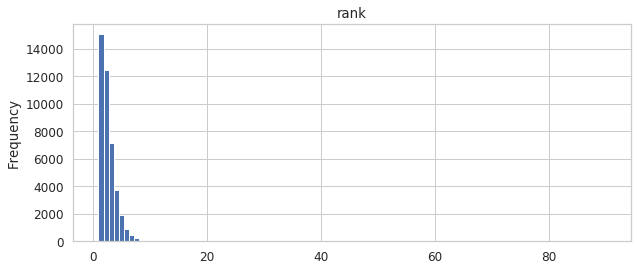

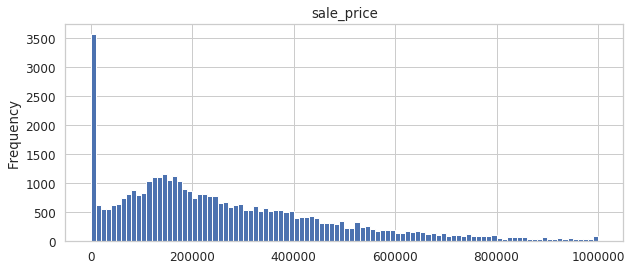

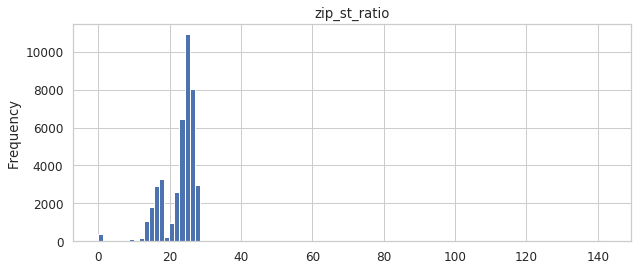

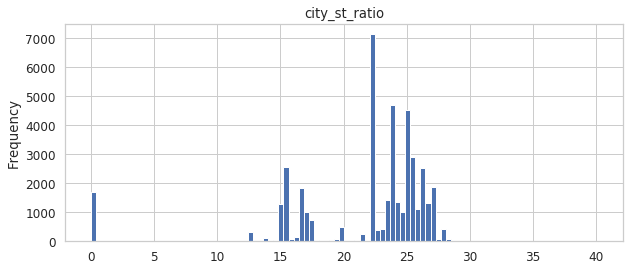

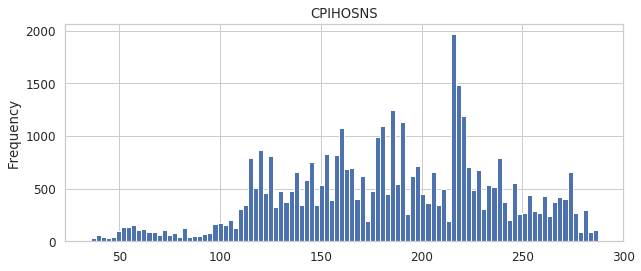

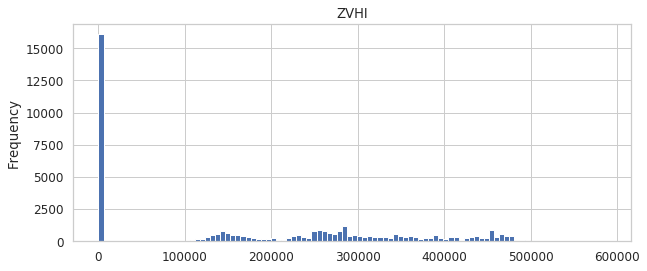

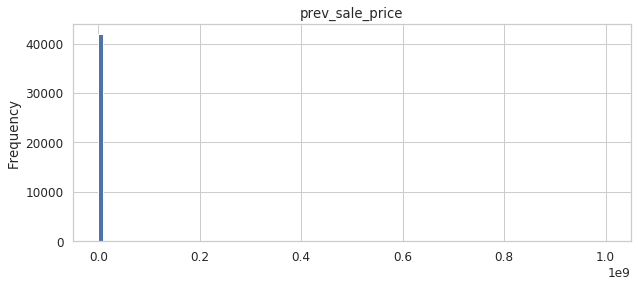

In [151]:
for column in sampled_data.columns:
    plt.figure(figsize=(10,4))
    sampled_data[column].plot(kind='hist', bins=100)
    plt.title(column)

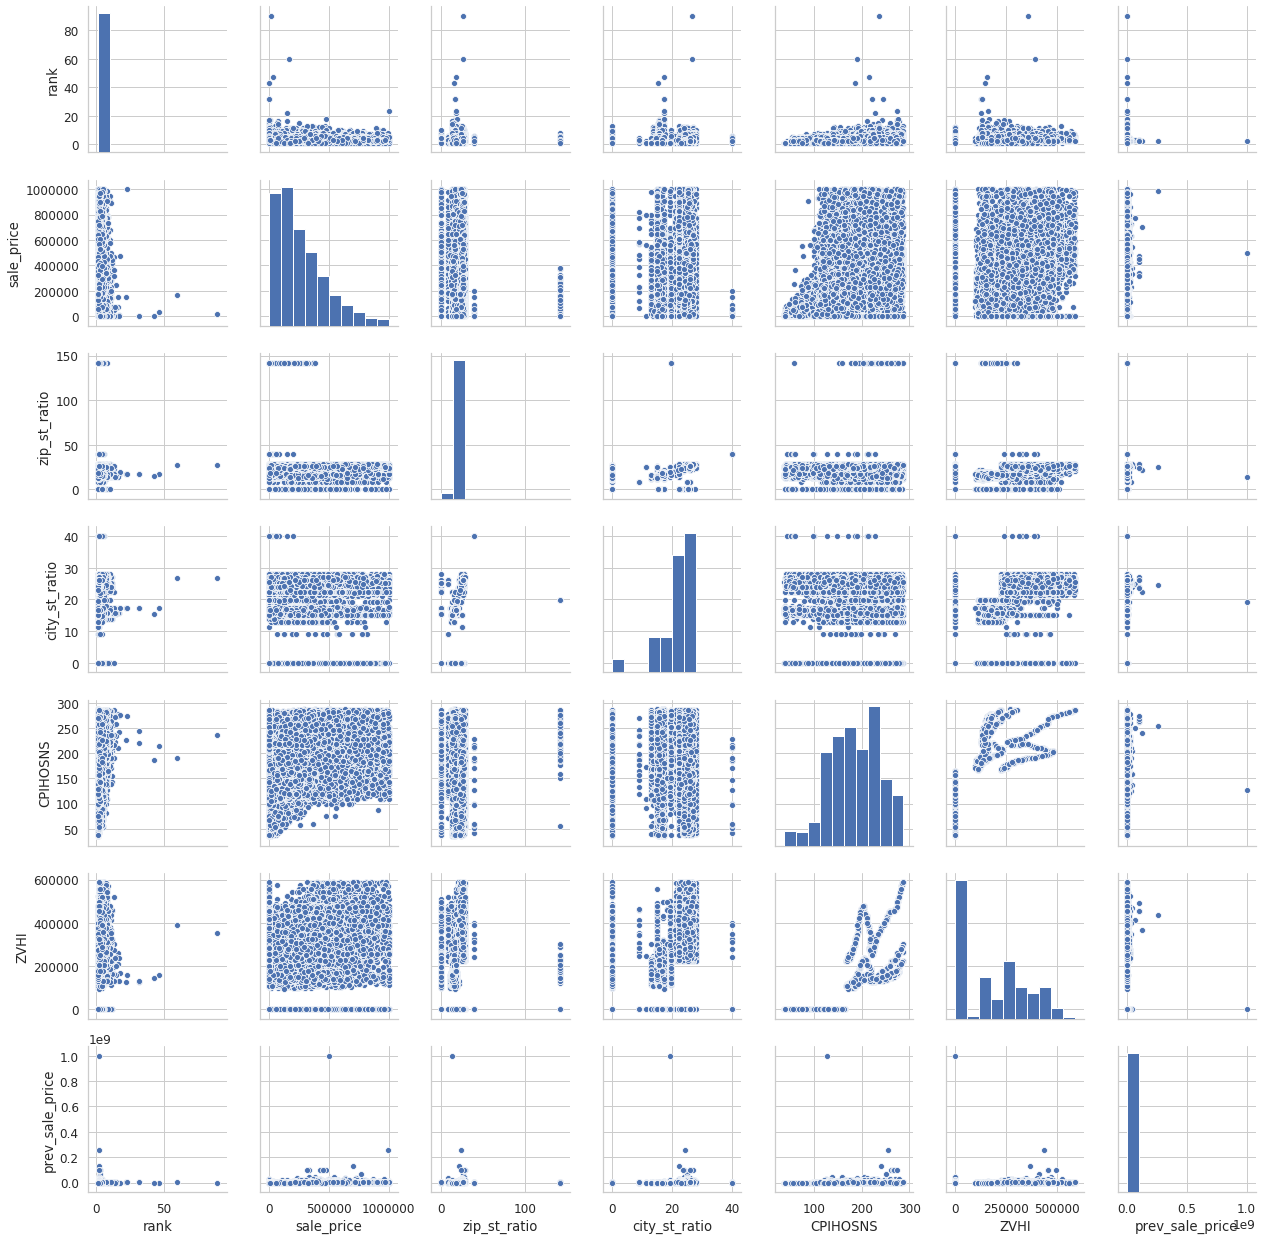

In [152]:
sns.pairplot(sampled_data)

In [ ]:
numerical_columns = sampled_data.columns 
for column in numerical_columns:
    plt.figure(figsize=(10,4))
    bank_df[column].plot(kind='hist', bins=50)
    plt.title(column)

In [ ]:
import seaborn as sns

sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    housing['SalePrice'], norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='Sale Price', ylabel='Count');

In [ ]:
#more feature correlation

In [ ]:
#correlation with y variable (sale_price)
y_corr = pd.DataFrame(columns=['Columns', 'Correlation Value'])
for x in df.columns:
    try:
        print(x)
        temp = pd.DataFrame([[x, df.corr("sale_price", x)]], columns=['Columns', 'Correlation Value'])
        y_corr = y_corr.append(temp)
    except:
        pass
y_corr

In [ ]:
x_vars = []
#all x variable correlation
x_corr = pd.DataFrame({"Variables" : x_vars})
for x in x_vars:
    temp2 = pd.DataFrame()
    for y in x_vars:
        print(str(x) + " and " + str(y))
        try:
            temp = pd.DataFrame([[df.corr(x,y)]], columns=[x])
#             temp = pd.DataFrame([["CORR"]], columns=[x])
            temp2 = temp2.append(temp)
        except:
            temp = pd.DataFrame([["N/A"]], columns=[x])
            temp2 = temp2.append(temp)
    x_corr = pd.concat([x_corr,temp2.reset_index().drop(columns="index")], axis=1)
x_corr

In [ ]:
import seaborn as sns
import numpy as np
# np.array(x_corr)
axis_labels = x_corr['Variables']
sns.heatmap(np.array(x_corr.set_index("Variables")), annot=False, fmt="g",vmin=0, vmax=1,linewidths=.5
           ,xticklabels=axis_labels, yticklabels=axis_labels)

### Y Variable analysis (Regression)

In [ ]:
### Aggregated sale count, avg price by sale year
sales_over_time = df.groupBy("sale_year").agg(F.mean(df.sale_price).alias("avg_sale_price"),
                                             F.count(df.sale_price).alias("sale_count")).toPandas()

In [ ]:
#plot sale count by sale year
ax = sales_over_time.sort_values(by="sale_year").plot(kind='line', x='sale_year', y='sale_count', figsize=(10,5))
ax.set_xlabel("Sale Year")
ax.set_ylabel("Sale Count")



In [ ]:
#plot avg sale price by sale year
ax = sales_over_time.sort_values(by="sale_year").plot(kind='bar', x='sale_year', y='avg_sale_price', figsize=(10,5))
ax.set_xlabel("Sale Year")
ax.set_ylabel("Average Sale Price")



In [ ]:
### Aggregated sale count, avg price by year built
sales_over_time2 = df.groupBy("year_built").agg(F.mean(df.sale_price).alias("avg_sale_price"),
                                             F.count(df.sale_price).alias("sale_count")).toPandas()



In [ ]:
#plot sale count by year built
ax = sales_over_time2.sort_values(by="year_built").plot(kind='line', x='year_built', y='sale_count', figsize=(10,5))
ax.set_xlabel("Year Built")
ax.set_ylabel("Sale Count")


In [ ]:
#plot avg sale price by year built
ax = sales_over_time2.sort_values(by="year_built").plot(kind='bar', x='year_built', y='avg_sale_price', figsize=(10,5))
ax.set_xlabel("Year Built")
ax.set_ylabel("Average Sale Price")

### Y variable analysis (classification)

In [ ]:
###Aggregate by profit flag: sale count, avg sale price
flag_agg = df.groupBy("price_flag")\
    .agg(F.mean(df.sale_price).alias("avg_sale_price"),
         F.count(df.sale_price).alias("sale_count"),
         F.mean(abs(df.sale_price - df.prev_sale_price)).alias("avg_sale_difference"))\
    .toPandas()
flag_agg['sale_count_perc'] = flag_agg['sale_count']/flag_agg['sale_count'].sum()
flag_agg


In [ ]:
#plot sale count by proft flag
ax = flag_agg.plot(kind='bar', x='price_flag', y='sale_count', figsize=(10,5))
ax.set_xlabel("Price Flag")
ax.set_ylabel("Sale Count")


In [ ]:
#pie chart for profit flag distribution
import matplotlib.pyplot as plt

# Pie chart
labels = flag_agg['price_flag'].tolist()
sizes = flag_agg['sale_count_perc'].tolist()
# only "explode" the 2nd slice (i.e. 'Hogs')
# explode = (0, 0.1, 0, 0)  
explode = (0, 0.1)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()

plt.title("Price Flag Distribution")

plt.show()


In [ ]:
#avg sale difference from previous sale to current sale, by profit flag
ax = flag_agg.plot(kind='bar', x='price_flag', y='avg_sale_difference', figsize=(10,5))
ax.set_xlabel("Price Flag")
ax.set_ylabel("Price Difference")

# FEATURE ENGINEERING

In [ ]:
# Convert city, state and zip to numeric categorical
for y in ['city', 'state', 'zip5']:
    print(y)
    indexer = StringIndexer(inputCol=str(y), outputCol=str(y)+"Index")
    ohe = OneHotEncoder(inputCol = str(y)+"Index", outputCol = str(y)+"Vector")
    df = indexer.fit(df).transform(df)
    df = ohe.transform(df)

In [ ]:
# property type clustering
## Create pipeline
# tokenization
tokenization = Tokenizer(inputCol="property_type", outputCol="p_words")
# stopwords
stopwords = StopWordsRemover(inputCol= "p_words", outputCol="p_filtered")
# some form of dimensionality reduction, word2vec
word2vec = Word2Vec(vectorSize=5, minCount=0, inputCol="p_filtered", outputCol="propertyVector")

pipeline = Pipeline().setStages([
    tokenization,
    stopwords,
    word2vec
])
# fit_pipeline = pipeline.fit(df)
df = pipeline.fit(df).transform(df)
# df
# Kmeans
kmeans = KMeans(featuresCol='propertyVector', predictionCol='propertyClusters', k=10, seed=123, maxIter=5)
k_mod = kmeans.fit(df)
df = k_mod.transform(df)

### Feature Reduction

In [ ]:
# Remove variables with low stddev
summary = df.describe().toPandas()\
    .set_index("summary").T\
    .sort_values(by="stddev")
summary['stddev'] = pd.to_numeric(summary['stddev'])
summary

In [ ]:
drop = summary[summary['stddev'] == 0].index
drop

# MODELING (Regression)

### Linear Regression

In [ ]:
#Section 6 - Multiple Linear Regression

In [53]:
from pyspark.ml.feature import VectorAssembler

In [159]:
lin_reg_df = df.filter(df['prev_sale_price'] > 0).na.fill(0)
lin_reg_df = lin_reg_df.withColumn('last_sale_days', datediff('sale_date',col("prev_sale_date")))
lin_reg_df = lin_reg_df.withColumn('last_sale_days', datediff('sale_date',col("prev_sale_date")))
lin_reg_df = lin_reg_df.withColumn('year_built', F.regexp_replace('year_built', ',', '').cast('decimal(12,2)'))
lin_reg_df = lin_reg_df.withColumn('sale_price', F.regexp_replace('sale_price', ',', '').cast('decimal(12,2)')).na.fill(0)
lin_reg_df = lin_reg_df.filter(col('sale_price') <= 1000000).filter(col('sale_price') >= 100000)

In [160]:
#predictors = ['CPIHOSNS', 'city_st_ratio', 'ZVHI','num_sales','zip_num_schools', 'zip_st_ratio', 'Median_Income', 'prev_sale_price']
predictors = ['year_built', 'prev_sale_price', 'last_sale_days', 'CPIHOSNS']

In [161]:
vectorAssembler = VectorAssembler(inputCols = predictors, outputCol = 'features')
vinput_data = vectorAssembler.transform(lin_reg_df)
vinput_data = vinput_data.select(['features', 'sale_price'])
vinput_data.show(1)

+--------------------+----------+
|            features|sale_price|
+--------------------+----------+
|[1974.0,187000.0,...| 267002.00|
+--------------------+----------+
only showing top 1 row



In [162]:
# Train/Test Split
train_df, test_df = vinput_data.randomSplit([.7,.3],seed=1234)

In [ ]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='sale_price', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-7.424860618237203,0.0010643436945267787,1.6025891524664069,1715.8461416744954]
Intercept: 12350.484045220797


In [172]:
trainingSummary = lr_model.summary

In [173]:
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 188047.541244
r2: 0.127166


In [ ]:
lr.predict(200000)

In [166]:
lin_reg_df.select(F.year(col('sale_date'))).distinct().show()

+-----+-----+--------------------+-----+--------------------+----+-----------+----------+----------+---------+----------+---------+---------------+----------------+-----------------+-----------------+--------+------------------+-------------+--------------+---------------+--------------+
| city|state|    physical_address| zip5|       property_type|rank|property_id| sale_date|sale_price|num_units|year_built|num_sales|zip_num_schools|city_num_schools|     zip_st_ratio|    city_st_ratio|CPIHOSNS|              ZVHI|Median_Income|prev_sale_date|prev_sale_price|last_sale_days|
+-----+-----+--------------------+-----+--------------------+----+-----------+----------+----------+---------+----------+---------+---------------+----------------+-----------------+-----------------+--------+------------------+-------------+--------------+---------------+--------------+
|ACTON|   CA|2830 SHANNON VALL...|93510|SINGLE FAMILY RES...|   2| 3217006001|2013-01-11| 267002.00|        1|   1974.00|        3|  

In [ ]:
lin_reg_df.select(F.year(col('sale_date'))).distinct().orderBy('year(sale_date)', ascending=False)

In [168]:
from pyspark.ml.regression import RandomForestRegressor

#tf_score_all = [['lable','f1_score','accuracy','ROC']]
rf = RandomForestRegressor(labelCol='sale_price', \
                        featuresCol="features", \
                        numTrees = 2, \
                        maxDepth = 3, \
                        maxBins = 32)
rfm = rf.fit(train_df)

In [181]:
predictions = rfm.transform(test_df)
predictions.select("prediction","sale_price","features").show()

+------------------+----------+--------------------+
|        prediction|sale_price|            features|
+------------------+----------+--------------------+
|261071.95785169938| 400000.00|[0.0,45000.0,90.0...|
|261071.95785169938| 385003.00|[0.0,75000.0,3724...|
|205397.73514419553| 167500.00|[0.0,85000.0,1088...|
|261071.95785169938| 175000.00|[0.0,202500.0,348...|
|403015.55797298776| 613525.00|[0.0,370000.0,271...|
| 448945.3278152549| 405000.00|[0.0,380000.0,14....|
|418585.30506314617| 365000.00|[1776.0,199090.0,...|
|418585.30506314617| 450000.00|[1890.0,127000.0,...|
|205397.73514419553| 139500.00|[1894.0,128000.0,...|
|  234525.020594072| 326000.00|[1897.0,189000.0,...|
|458219.34302639763| 606006.00|[1898.0,329003.0,...|
| 545557.9097045242| 721007.00|[1898.0,587505.0,...|
| 448945.3278152549| 641497.00|[1899.0,630000.0,...|
|  234525.020594072| 200000.00|[1900.0,218000.0,...|
|261071.95785169938| 255002.00|[1902.0,95000.0,2...|
|403015.55797298776| 180000.00|[1902.0,330000.

In [183]:
from pyspark.ml.evaluation import RegressionEvaluator
rf_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="sale_price",metricName="r2")
print("R Squared (R2) on test data = %g" % rf_evaluator.evaluate(predictions))

R Squared (R2) on test data = 0.344719


In [ ]:
dt_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="rmse")
rmse = rf_evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

### Linear Regression (GLM)

In [ ]:
from pyspark.ml.regression import GeneralizedLinearRegression
#ridge
glr = GeneralizedLinearRegression(family="gaussian", link="identity", maxIter=5, regParam=0)
model = glr.fit(dataset)
summary = model.summary
print("Coefficient Standard Errors: " + str(summary.coefficientStandardErrors))
print("P Values: " + str(summary.pValues))

In [ ]:
linreg_predictions_train = model.transform(train_df)
linreg_predictions_test = model.transform(test_df)

In [ ]:
## Train data
lr_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="rmse")
rmse = lr_evaluator.evaluate(linreg_predictions_train)
print("Root Mean Squared Error (RMSE) on train data = %g" % rmse)

lr_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="r2")
r2 = lr_evaluator.evaluate(linreg_predictions_train)
print("R Squared (R2) on train data = %g" % r2)

lr_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="mae")
mae = lr_evaluator.evaluate(linreg_predictions_train)
print("Mean Absolute Error (MAE) on train data = %g" % mae)

lr_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="mse")
mse = lr_evaluator.evaluate(linreg_predictions_train)
print("Mean Squared Error (MSE) on train data = %g" % mse)

In [ ]:
## Test data
lr_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="rmse")
rmse = lr_evaluator.evaluate(linreg_predictions_test)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

lr_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="r2")
r2 = lr_evaluator.evaluate(linreg_predictions_test)
print("R Squared (R2) on test data = %g" % r2)

lr_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="mae")
mae = lr_evaluator.evaluate(linreg_predictions_test)
print("Mean Absolute Error (MAE) on test data = %g" % mae)

lr_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="mse")
mse = lr_evaluator.evaluate(linreg_predictions_test)
print("Mean Squared Error (MSE) on test data = %g" % mse)

### Random Forest

### Gradient Boosting

In [ ]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'sale_price', maxIter=5)
gbt_model = gbt.fit(train_df)

In [ ]:
gbt_predictions_train = gbt_model.transform(train_df)
gbt_predictions_test = gbt_model.transform(test_df)

In [ ]:
## Train data
gbt_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions_train)
print("Root Mean Squared Error (RMSE) on train data = %g" % rmse)

gbt_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="r2")
r2 = gbt_evaluator.evaluate(gbt_predictions_train)
print("R Squared (R2) on train data = %g" % r2)

gbt_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="mae")
mae = gbt_evaluator.evaluate(gbt_predictions_train)
print("Mean Absolute Error (MAE) on train data = %g" % mae)

gbt_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="mse")
mse = gbt_evaluator.evaluate(gbt_predictions_train)
print("Mean Squared Error (MSE) on train data = %g" % mse)

In [ ]:
## Test data
gbt_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions_test)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

gbt_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="r2")
r2 = gbt_evaluator.evaluate(gbt_predictions_test)
print("R Squared (R2) on test data = %g" % r2)

gbt_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="mae")
mae = gbt_evaluator.evaluate(gbt_predictions_test)
print("Mean Absolute Error (MAE) on test data = %g" % mae)

gbt_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="mse")
mse = gbt_evaluator.evaluate(gbt_predictions_test)
print("Mean Squared Error (MSE) on test data = %g" % mse)

In [ ]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))


In [ ]:
feature_imp = ExtractFeatureImp(gbt_model.featureImportances, train_df, "features")

In [ ]:
ax = feature_imp.sort_values(by='score', ascending=True).tail(10).plot(kind='barh', x = 'name', y = 'score')\

ax.set_xlabel("Variables")
ax.set_ylabel("Feature Importance")

# MODELING (Classification)

In [ ]:
# ## create flag var
# lin_reg_df = lin_reg_df.withColumn(
#     'price_flag',
#     F.when(F.col("sale_price") > F.col("prev_sale_price"), 1)\
#     .otherwise(0)
# )

In [ ]:
class_df = df.filter(df['prev_sale_price'] > 0).na.fill(0)

In [ ]:
#target variable
class_df = class_df.withColumn('profit_is_pos', (class_df['sale_price'] - class_df['prev_sale_price'] ))
class_df = class_df.withColumn("profit_is_pos", when(F.col('profit_is_pos') >= 0 ,1).otherwise(0))
df_2 = class_df.select('state', 'city', 'zip5', 'year_built', 'CPIHOSNS', 'prev_sale_price',
                       'property_type', 'last_sale_days','profit_is_pos')

In [ ]:
predictors = ['year_built', 'prev_sale_price', 'last_sale_days', 'CPIHOSNS', 'cityVector', 'stateVector', 'zip5Vector']

vectorAssembler = VectorAssembler(inputCols = predictors, outputCol = 'features')
vinput_data = vectorAssembler.transform(df_2)
vinput_data = vinput_data.select(['features', 'profit_is_pos'])
vinput_data.show(1)

### Naive Bayes

In [ ]:
train_df.select('profit_is_pos').groupBy('profit_is_pos').count().show()

In [ ]:
nb = NaiveBayes(modelType='multinomial',labelCol = 'profit_is_pos')
nbmodel = nb.fit(train_df)
predictions_nb = nbmodel.transform(test_df)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='profit_is_pos', predictionCol="prediction", metricName="accuracy") 
nbaccuracy = evaluator.evaluate(predictions_nb) 
print("Test accuracy = " + str(nbaccuracy))
Test accuracy = 0.7067928508643422
evaluator = MulticlassClassificationEvaluator(labelCol='profit_is_pos', predictionCol="prediction", metricName="f1") 
nbf1 = evaluator.evaluate(predictions_nb) 
print("Test f1 = " + str(nbf1))
Test f1 = 0.6803030399280371
evaluator = MulticlassClassificationEvaluator(labelCol='profit_is_pos', predictionCol="prediction", metricName="weightedRecall") 
nbcall = evaluator.evaluate(predictions_nb) 
print("Test recall = " + str(nbcall))
Test recall = 0.7067928508643423
evaluator = MulticlassClassificationEvaluator(labelCol='profit_is_pos', predictionCol="prediction", metricName="weightedPrecision") 
nbcall = evaluator.evaluate(predictions_nb) 
print("Precision = " + str(nbcall))
Precision = 0.6787251686730787
bcEvaluator = BinaryClassificationEvaluator(metricName="areaUnderROC",labelCol='profit_is_pos')
print("Area under ROC curve:", bcEvaluator.evaluate(predictions_nb))

### Logistic Regression

In [ ]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0,labelCol = 'profit_is_pos')

lrm = lr.fit(train_df)
predictions_lr = lrm.transform(test_df)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='profit_is_pos', predictionCol="prediction", metricName="accuracy") 
nbaccuracy = evaluator.evaluate(predictions_lr) 
print("Test accuracy = " + str(nbaccuracy))
Test accuracy = 0.6994104893055962
evaluator = MulticlassClassificationEvaluator(labelCol='profit_is_pos', predictionCol="prediction", metricName="f1") 
nbf1 = evaluator.evaluate(predictions_lr) 
print("Test f1 = " + str(nbf1))
Test f1 = 0.5765969490729765
evaluator = MulticlassClassificationEvaluator(labelCol='profit_is_pos', predictionCol="prediction", metricName="weightedRecall") 
nbcall = evaluator.evaluate(predictions_lr) 
print("Test recall = " + str(nbcall))
Test recall = 0.6994104893055962
evaluator = MulticlassClassificationEvaluator(labelCol='profit_is_pos', predictionCol="prediction", metricName="weightedPrecision") 
nbcall = evaluator.evaluate(predictions_lr) 
print("Precision = " + str(nbcall))
Precision = 0.7082292566625992
bcEvaluator = BinaryClassificationEvaluator(metricName="areaUnderROC", labelCol='profit_is_pos')
print("Area under ROC curve:", bcEvaluator.evaluate(predictions_lr))


### Random Forest

In [ ]:
tf_score_all = [['profit_is_pos','f1_score','accuracy','Recall', 'ROC']]

rf = RandomForestClassifier(labelCol='profit_is_pos', \
                        featuresCol="features", \
                        numTrees = 50, \
                        maxDepth = 3, \
                        maxBins = 32)
rfm = rf.fit(train_df)
predictions = rfm.transform(test_df)
results = predictions.select(['prediction','profit_is_pos'])
predictionAndLabels=results.rdd

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
metrics = MulticlassMetrics(predictionAndLabels)
metrics_binary = BinaryClassificationMetrics(predictionAndLabels)
evaluator = MulticlassClassificationEvaluator(labelCol='profit_is_pos', predictionCol="prediction", metricName="accuracy") 
nbaccuracy = evaluator.evaluate(predictions) 
print("Test accuracy = " + str(nbaccuracy))
Test accuracy = 0.69898740111339
evaluator = MulticlassClassificationEvaluator(labelCol='profit_is_pos', predictionCol="prediction", metricName="f1") 
nbf1 = evaluator.evaluate(predictions) 
print("Test f1 = " + str(nbf1))
Test f1 = 0.575146568591468
evaluator = MulticlassClassificationEvaluator(labelCol='profit_is_pos', predictionCol="prediction", metricName="weightedPrecision") 
nbcall = evaluator.evaluate(predictions) 
print("Precision = " + str(nbcall))
Precision = 0.48858338691525116
evaluator = MulticlassClassificationEvaluator(labelCol='profit_is_pos', predictionCol="prediction", metricName="weightedRecall") 
nbcall = evaluator.evaluate(predictions) 
print("Test recall = " + str(nbcall))

In [ ]:
#feature importance
ExtractFeatureImp(mod.stages[-1].featureImportances, df_2, "features_subset") #df2 is the model with highest accuracy

### Gradient Boosting

In [ ]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol=y_var, featuresCol="features", maxIter=5)
gbt_model = gbt.fit(train_df)

In [ ]:
gbt_predictions_train = gbt_model.transform(train_df)
gbt_predictions_test = gbt_model.transform(test_df)

In [ ]:
gbt_predictions_train.columns

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Create both evaluators
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="price_flag", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="price_flag", rawPredictionCol="prediction", metricName='areaUnderROC')

# Make predicitons
predictionAndprice_flag = gbt_predictions_train.select("price_flag", "prediction")

# Get metrics
acc = evaluatorMulti.evaluate(predictionAndprice_flag, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictionAndprice_flag, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndprice_flag, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndprice_flag, {evaluatorMulti.metricName: "weightedRecall"})
auc = evaluator.evaluate(predictionAndprice_flag)

In [ ]:
print("Train Data performance")
print(acc)
print(f1)
print(weightedPrecision)
print(weightedRecall)

In [ ]:
## test results

# Make predicitons
predictionAndprice_flag = gbt_predictions_test.select("price_flag", "prediction")

# Get metrics
acc = evaluatorMulti.evaluate(predictionAndprice_flag, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictionAndprice_flag, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndprice_flag, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndprice_flag, {evaluatorMulti.metricName: "weightedRecall"})
auc = evaluator.evaluate(predictionAndprice_flag)

In [ ]:
print("Test Data performance")
print(acc)
print(f1)
print(weightedPrecision)
print(weightedRecall)

In [ ]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))


In [ ]:
feature_imp = ExtractFeatureImp(gbt_model.featureImportances, train_df, "features")
feature_imp